In [136]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl
from uncertainties import unumpy as up

In [137]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [138]:
def pos(x,pos):
    for i in range(len(pos)):
        if pos[i]>=x:
            return i
            break

In [139]:
def gaus1fit(von,bis,path,x,y,err,yscale,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 

            
    data=[x,y,err]
    vonarr = pos(von,x)
    bisarr = pos(bis,x)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=y[vonarr:bisarr],x=x[vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(y[vonarr:bisarr],x=x[vonarr:bisarr],weights=1/err[vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(x[vonarr:bisarr],yscale*y[vonarr:bisarr],yerr=yscale*err[vonarr:bisarr],fmt='.',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.errorbar(x[0:vonarr],yscale*y[0:vonarr],yerr=yscale*err[0:vonarr],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.errorbar(x[bisarr:-1],yscale*y[bisarr:-1],yerr=yscale*err[bisarr:-1],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)

    plt.plot(np.arange(26,29,0.01),yscale*out_gaus.eval(x=np.arange(26,29,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    #print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]), out_gaus

def gaus2fit(von,bis,path,x,y,err,yscale,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 


    data=[x,y,err]
    vonarr = pos(von,x)
    bisarr = pos(bis,x)



    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(y,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=y[vonarr:bisarr],x=x[vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1,min=0)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2,min=0)


    #Fitten
    out_gaus = model_gaus.fit(y[vonarr:bisarr],x=x[vonarr:bisarr],weights=1/err[vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(x[vonarr:bisarr],yscale*y[vonarr:bisarr],yerr=yscale*err[vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.errorbar(x[0:vonarr],yscale*y[0:vonarr],yerr=yscale*err[0:vonarr],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.errorbar(x[bisarr:-1],yscale*y[bisarr:-1],yerr=yscale*err[bisarr:-1],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.plot(np.arange(26,29,0.01),yscale*out_gaus.eval(x=np.arange(26,29,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01), out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus

In [140]:
fig = plt.figure(figsize=(20,10),dpi=80,linewidth=50)
x = [[],[],[]]
data = []
err = []
for i in range(len(os.listdir('Data'))):
    path = 'Data/'+os.listdir('Data')[i]
    print(path)
    with open(path) as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        if len(dataex[3])==151:
            x[0] = dataex[3]
        elif len(dataex[3])==101:
            x[1] = dataex[3]
        elif len(dataex[3])==201:
            x[2] = dataex[3] 
        else:
            print('Error')
        
        data.append(dataex[4])
        err.append(dataex[4]*0.05)


Data/Deltam -0%.csv
Data/Deltam -10%.csv
Data/Deltam -20%.csv
Data/Deltam -30%.csv
Data/Deltam -40%.csv
Data/Deltam -50%.csv
Data/Deltam -60%.csv
Data/Deltam -70%.csv
Data/Deltam -80%.csv
Data/Deltam -90%.csv
Data/Deltam -100%.csv
Data/Deltam -100%V2.csv
Data/Deltam 10%.csv
Data/Deltam 20%.csv
Data/Deltam 30%.csv
Data/Deltam 40%.csv
Data/Deltam 50%.csv
Data/Deltam 60%.csv
Data/Deltam 70%.csv
Data/Deltam 80%.csv
Data/Deltam 90%.csv
Data/Deltam 100%.csv


<Figure size 1600x800 with 0 Axes>

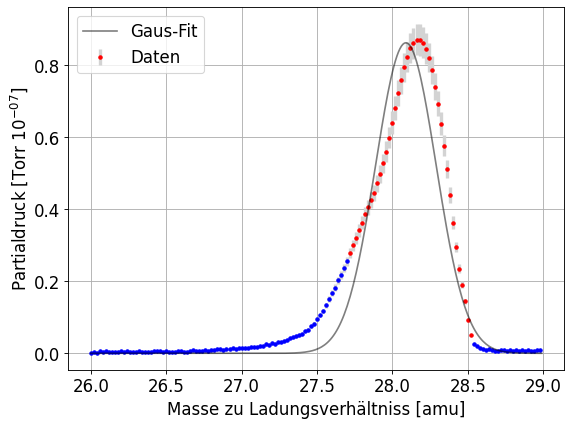

In [141]:
fit0 = gaus1fit(27.72,28.53,'0%',x[0],data[0],err[0],1e7)

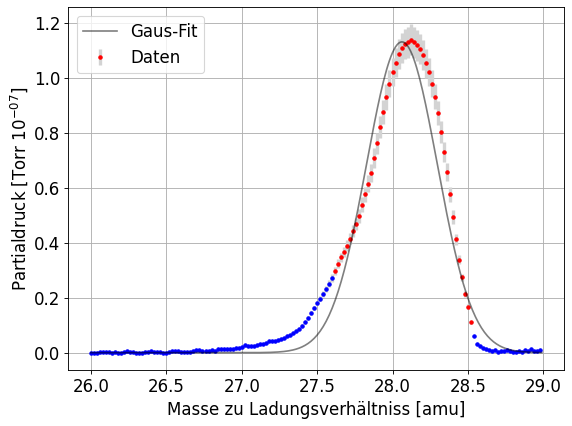

In [142]:
fit0 = gaus1fit(27.62,28.53,'-10%',x[0],data[1],err[1],1e7)

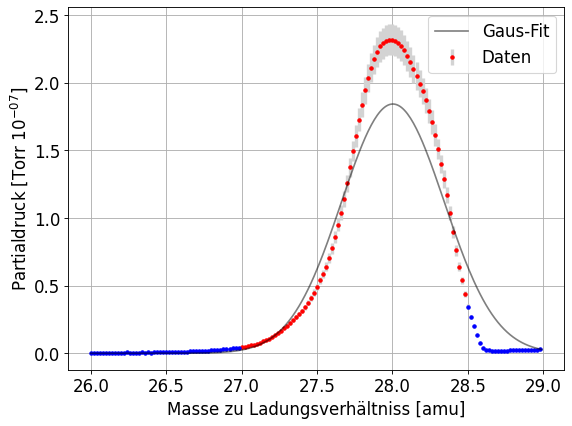

In [143]:
fit0 = gaus1fit(27,28.5,'-20%',x[0],data[3],err[3],1e7)

(array([[2.73800000e+01, 2.73900000e+01, 2.74000000e+01, 2.74100000e+01,
         2.74200000e+01, 2.74300000e+01, 2.74400000e+01, 2.74500000e+01,
         2.74600000e+01, 2.74700000e+01, 2.74800000e+01, 2.74900000e+01,
         2.75000000e+01, 2.75100000e+01, 2.75200000e+01, 2.75300000e+01,
         2.75400000e+01, 2.75500000e+01, 2.75600000e+01, 2.75700000e+01,
         2.75800000e+01, 2.75900000e+01, 2.76000000e+01, 2.76100000e+01,
         2.76200000e+01, 2.76300000e+01, 2.76400000e+01, 2.76500000e+01,
         2.76600000e+01, 2.76700000e+01, 2.76800000e+01, 2.76900000e+01,
         2.77000000e+01, 2.77100000e+01, 2.77200000e+01, 2.77300000e+01,
         2.77400000e+01, 2.77500000e+01, 2.77600000e+01, 2.77700000e+01,
         2.77800000e+01, 2.77900000e+01, 2.78000000e+01, 2.78100000e+01,
         2.78200000e+01, 2.78300000e+01, 2.78400000e+01, 2.78500000e+01,
         2.78600000e+01, 2.78700000e+01, 2.78800000e+01, 2.78900000e+01,
         2.79000000e+01, 2.79100000e+01, 2.79200000

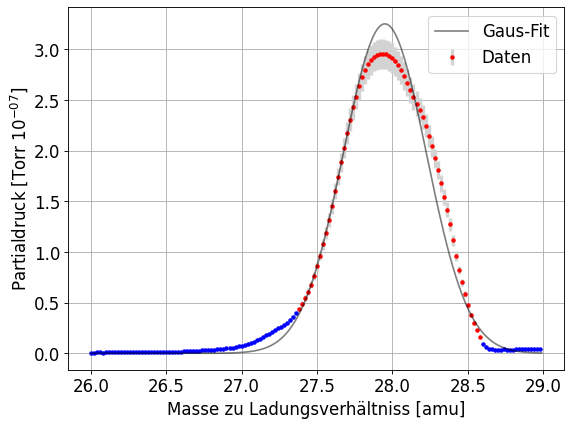

In [144]:
gaus1fit(27.38,28.6,'-30%',x[0],data[4],err[4],1e7)

(array([[2.72500000e+01, 2.72600000e+01, 2.72700000e+01, 2.72800000e+01,
         2.72900000e+01, 2.73000000e+01, 2.73100000e+01, 2.73200000e+01,
         2.73300000e+01, 2.73400000e+01, 2.73500000e+01, 2.73600000e+01,
         2.73700000e+01, 2.73800000e+01, 2.73900000e+01, 2.74000000e+01,
         2.74100000e+01, 2.74200000e+01, 2.74300000e+01, 2.74400000e+01,
         2.74500000e+01, 2.74600000e+01, 2.74700000e+01, 2.74800000e+01,
         2.74900000e+01, 2.75000000e+01, 2.75100000e+01, 2.75200000e+01,
         2.75300000e+01, 2.75400000e+01, 2.75500000e+01, 2.75600000e+01,
         2.75700000e+01, 2.75800000e+01, 2.75900000e+01, 2.76000000e+01,
         2.76100000e+01, 2.76200000e+01, 2.76300000e+01, 2.76400000e+01,
         2.76500000e+01, 2.76600000e+01, 2.76700000e+01, 2.76800000e+01,
         2.76900000e+01, 2.77000000e+01, 2.77100000e+01, 2.77200000e+01,
         2.77300000e+01, 2.77400000e+01, 2.77500000e+01, 2.77600000e+01,
         2.77700000e+01, 2.77800000e+01, 2.77900000

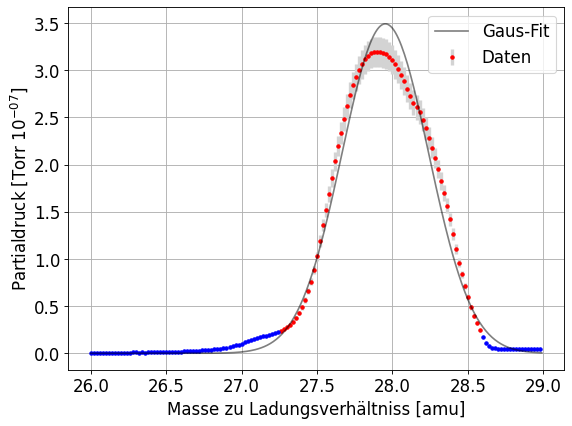

In [145]:
gaus1fit(27.25,28.6,'-40%',x[0],data[5],err[5],1e7)

(array([[2.71200000e+01, 2.71300000e+01, 2.71400000e+01, 2.71500000e+01,
         2.71600000e+01, 2.71700000e+01, 2.71800000e+01, 2.71900000e+01,
         2.72000000e+01, 2.72100000e+01, 2.72200000e+01, 2.72300000e+01,
         2.72400000e+01, 2.72500000e+01, 2.72600000e+01, 2.72700000e+01,
         2.72800000e+01, 2.72900000e+01, 2.73000000e+01, 2.73100000e+01,
         2.73200000e+01, 2.73300000e+01, 2.73400000e+01, 2.73500000e+01,
         2.73600000e+01, 2.73700000e+01, 2.73800000e+01, 2.73900000e+01,
         2.74000000e+01, 2.74100000e+01, 2.74200000e+01, 2.74300000e+01,
         2.74400000e+01, 2.74500000e+01, 2.74600000e+01, 2.74700000e+01,
         2.74800000e+01, 2.74900000e+01, 2.75000000e+01, 2.75100000e+01,
         2.75200000e+01, 2.75300000e+01, 2.75400000e+01, 2.75500000e+01,
         2.75600000e+01, 2.75700000e+01, 2.75800000e+01, 2.75900000e+01,
         2.76000000e+01, 2.76100000e+01, 2.76200000e+01, 2.76300000e+01,
         2.76400000e+01, 2.76500000e+01, 2.76600000

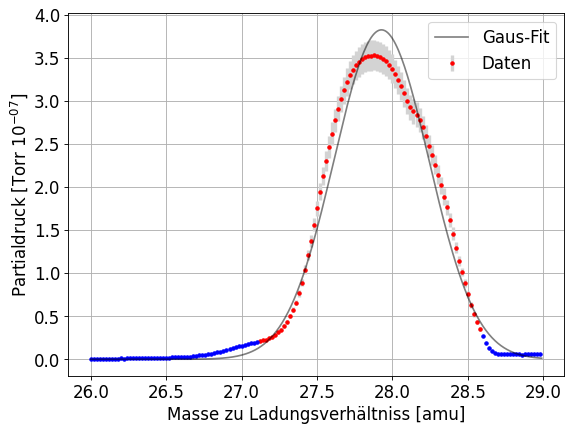

In [146]:
gaus1fit(27.12,28.6,'-50%',x[0],data[6],err[6],1e7)

(array([[2.70300000e+01, 2.70400000e+01, 2.70500000e+01, 2.70600000e+01,
         2.70700000e+01, 2.70800000e+01, 2.70900000e+01, 2.71000000e+01,
         2.71100000e+01, 2.71200000e+01, 2.71300000e+01, 2.71400000e+01,
         2.71500000e+01, 2.71600000e+01, 2.71700000e+01, 2.71800000e+01,
         2.71900000e+01, 2.72000000e+01, 2.72100000e+01, 2.72200000e+01,
         2.72300000e+01, 2.72400000e+01, 2.72500000e+01, 2.72600000e+01,
         2.72700000e+01, 2.72800000e+01, 2.72900000e+01, 2.73000000e+01,
         2.73100000e+01, 2.73200000e+01, 2.73300000e+01, 2.73400000e+01,
         2.73500000e+01, 2.73600000e+01, 2.73700000e+01, 2.73800000e+01,
         2.73900000e+01, 2.74000000e+01, 2.74100000e+01, 2.74200000e+01,
         2.74300000e+01, 2.74400000e+01, 2.74500000e+01, 2.74600000e+01,
         2.74700000e+01, 2.74800000e+01, 2.74900000e+01, 2.75000000e+01,
         2.75100000e+01, 2.75200000e+01, 2.75300000e+01, 2.75400000e+01,
         2.75500000e+01, 2.75600000e+01, 2.75700000

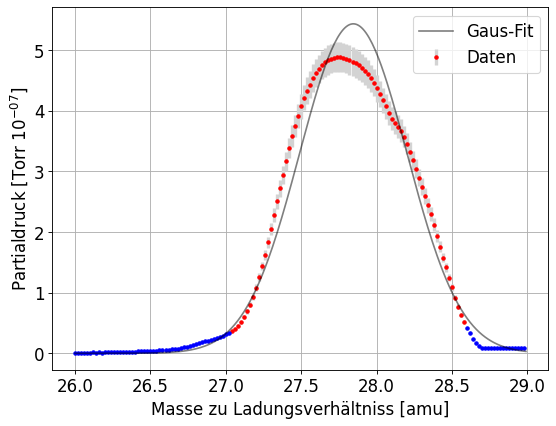

In [147]:
gaus1fit(27.03,28.6,'-60%',x[0],data[7],err[7],1e7)

(array([[2.70300000e+01, 2.70400000e+01, 2.70500000e+01, 2.70600000e+01,
         2.70700000e+01, 2.70800000e+01, 2.70900000e+01, 2.71000000e+01,
         2.71100000e+01, 2.71200000e+01, 2.71300000e+01, 2.71400000e+01,
         2.71500000e+01, 2.71600000e+01, 2.71700000e+01, 2.71800000e+01,
         2.71900000e+01, 2.72000000e+01, 2.72100000e+01, 2.72200000e+01,
         2.72300000e+01, 2.72400000e+01, 2.72500000e+01, 2.72600000e+01,
         2.72700000e+01, 2.72800000e+01, 2.72900000e+01, 2.73000000e+01,
         2.73100000e+01, 2.73200000e+01, 2.73300000e+01, 2.73400000e+01,
         2.73500000e+01, 2.73600000e+01, 2.73700000e+01, 2.73800000e+01,
         2.73900000e+01, 2.74000000e+01, 2.74100000e+01, 2.74200000e+01,
         2.74300000e+01, 2.74400000e+01, 2.74500000e+01, 2.74600000e+01,
         2.74700000e+01, 2.74800000e+01, 2.74900000e+01, 2.75000000e+01,
         2.75100000e+01, 2.75200000e+01, 2.75300000e+01, 2.75400000e+01,
         2.75500000e+01, 2.75600000e+01, 2.75700000

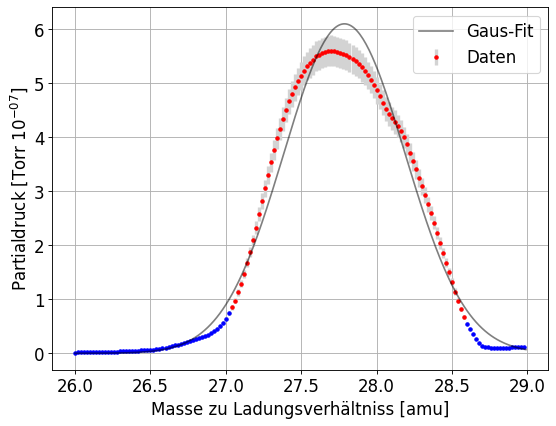

In [148]:
gaus1fit(27.03,28.6,'-70%',x[0],data[8],err[8],1e7)

(array([[2.70300000e+01, 2.70400000e+01, 2.70500000e+01, 2.70600000e+01,
         2.70700000e+01, 2.70800000e+01, 2.70900000e+01, 2.71000000e+01,
         2.71100000e+01, 2.71200000e+01, 2.71300000e+01, 2.71400000e+01,
         2.71500000e+01, 2.71600000e+01, 2.71700000e+01, 2.71800000e+01,
         2.71900000e+01, 2.72000000e+01, 2.72100000e+01, 2.72200000e+01,
         2.72300000e+01, 2.72400000e+01, 2.72500000e+01, 2.72600000e+01,
         2.72700000e+01, 2.72800000e+01, 2.72900000e+01, 2.73000000e+01,
         2.73100000e+01, 2.73200000e+01, 2.73300000e+01, 2.73400000e+01,
         2.73500000e+01, 2.73600000e+01, 2.73700000e+01, 2.73800000e+01,
         2.73900000e+01, 2.74000000e+01, 2.74100000e+01, 2.74200000e+01,
         2.74300000e+01, 2.74400000e+01, 2.74500000e+01, 2.74600000e+01,
         2.74700000e+01, 2.74800000e+01, 2.74900000e+01, 2.75000000e+01,
         2.75100000e+01, 2.75200000e+01, 2.75300000e+01, 2.75400000e+01,
         2.75500000e+01, 2.75600000e+01, 2.75700000

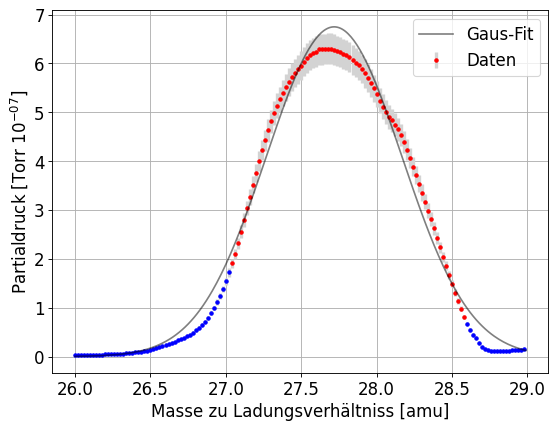

In [149]:
gaus1fit(27.03,28.6,'-80%',x[0],data[9],err[9],1e7)

(array([[2.70300000e+01, 2.70400000e+01, 2.70500000e+01, 2.70600000e+01,
         2.70700000e+01, 2.70800000e+01, 2.70900000e+01, 2.71000000e+01,
         2.71100000e+01, 2.71200000e+01, 2.71300000e+01, 2.71400000e+01,
         2.71500000e+01, 2.71600000e+01, 2.71700000e+01, 2.71800000e+01,
         2.71900000e+01, 2.72000000e+01, 2.72100000e+01, 2.72200000e+01,
         2.72300000e+01, 2.72400000e+01, 2.72500000e+01, 2.72600000e+01,
         2.72700000e+01, 2.72800000e+01, 2.72900000e+01, 2.73000000e+01,
         2.73100000e+01, 2.73200000e+01, 2.73300000e+01, 2.73400000e+01,
         2.73500000e+01, 2.73600000e+01, 2.73700000e+01, 2.73800000e+01,
         2.73900000e+01, 2.74000000e+01, 2.74100000e+01, 2.74200000e+01,
         2.74300000e+01, 2.74400000e+01, 2.74500000e+01, 2.74600000e+01,
         2.74700000e+01, 2.74800000e+01, 2.74900000e+01, 2.75000000e+01,
         2.75100000e+01, 2.75200000e+01, 2.75300000e+01, 2.75400000e+01,
         2.75500000e+01, 2.75600000e+01, 2.75700000

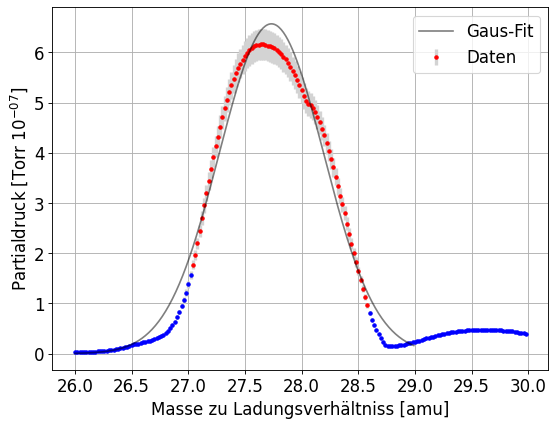

In [150]:
gaus1fit(27.03,28.6,'-90%',x[2],data[10],err[10],1e7)

(array([[2.70300000e+01, 2.70400000e+01, 2.70500000e+01, 2.70600000e+01,
         2.70700000e+01, 2.70800000e+01, 2.70900000e+01, 2.71000000e+01,
         2.71100000e+01, 2.71200000e+01, 2.71300000e+01, 2.71400000e+01,
         2.71500000e+01, 2.71600000e+01, 2.71700000e+01, 2.71800000e+01,
         2.71900000e+01, 2.72000000e+01, 2.72100000e+01, 2.72200000e+01,
         2.72300000e+01, 2.72400000e+01, 2.72500000e+01, 2.72600000e+01,
         2.72700000e+01, 2.72800000e+01, 2.72900000e+01, 2.73000000e+01,
         2.73100000e+01, 2.73200000e+01, 2.73300000e+01, 2.73400000e+01,
         2.73500000e+01, 2.73600000e+01, 2.73700000e+01, 2.73800000e+01,
         2.73900000e+01, 2.74000000e+01, 2.74100000e+01, 2.74200000e+01,
         2.74300000e+01, 2.74400000e+01, 2.74500000e+01, 2.74600000e+01,
         2.74700000e+01, 2.74800000e+01, 2.74900000e+01, 2.75000000e+01,
         2.75100000e+01, 2.75200000e+01, 2.75300000e+01, 2.75400000e+01,
         2.75500000e+01, 2.75600000e+01, 2.75700000

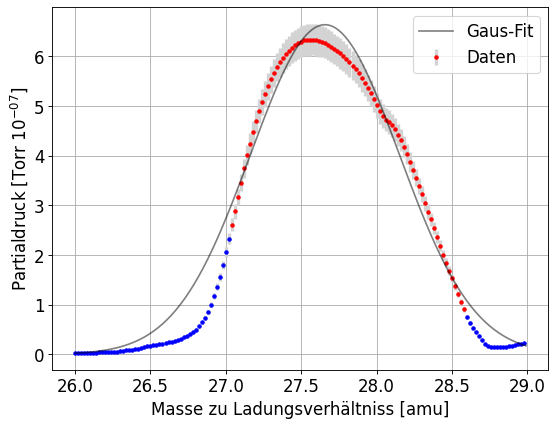

In [151]:
gaus1fit(27.03,28.6,'-100%',x[0],data[11],err[11],1e7)

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 50
    # variables        = 6
    chi-square         = 39.4498633
    reduced chi-square = 0.89658780
    Akaike info crit   = 0.15037879
    Bayesian info crit = 11.6225168
[[Variables]]
    g1_amplitude:  9.7827e-09 +/- 8.0005e-10 (8.18%) (init = 1e-07)
    g1_center:     28.2547939 +/- 0.00349961 (0.01%) (init = 28.4)
    g1_sigma:      0.11299937 +/- 0.00609207 (5.39%) (init = 0.3)
    g2_amplitude:  1.9371e-08 +/- 1.7130e-09 (8.84%) (init = 3e-08)
    g2_center:     27.9817257 +/- 0.01812697 (0.06%) (init = 27.9)
    g2_sigma:      0.23843774 +/- 0.00809026 (3.39%) (init = 0.3)
    g1_fwhm:       0.26609317 +/- 0.01434572 (5.39%) == '2.3548200*g1_sigma'
    g1_height:     3.4538e-08 +/- 1.2240e-09 (3.54%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.56147797 +/- 0.01905111 (3

(array([[2.75000000e+01, 2.75100000e+01, 2.75200000e+01, 2.75300000e+01,
         2.75400000e+01, 2.75500000e+01, 2.75600000e+01, 2.75700000e+01,
         2.75800000e+01, 2.75900000e+01, 2.76000000e+01, 2.76100000e+01,
         2.76200000e+01, 2.76300000e+01, 2.76400000e+01, 2.76500000e+01,
         2.76600000e+01, 2.76700000e+01, 2.76800000e+01, 2.76900000e+01,
         2.77000000e+01, 2.77100000e+01, 2.77200000e+01, 2.77300000e+01,
         2.77400000e+01, 2.77500000e+01, 2.77600000e+01, 2.77700000e+01,
         2.77800000e+01, 2.77900000e+01, 2.78000000e+01, 2.78100000e+01,
         2.78200000e+01, 2.78300000e+01, 2.78400000e+01, 2.78500000e+01,
         2.78600000e+01, 2.78700000e+01, 2.78800000e+01, 2.78900000e+01,
         2.79000000e+01, 2.79100000e+01, 2.79200000e+01, 2.79300000e+01,
         2.79400000e+01, 2.79500000e+01, 2.79600000e+01, 2.79700000e+01,
         2.79800000e+01, 2.79900000e+01, 2.80000000e+01, 2.80100000e+01,
         2.80200000e+01, 2.80300000e+01, 2.80400000

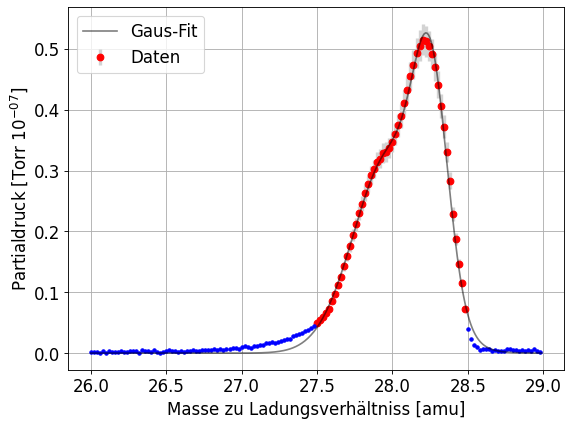

In [165]:
gaus2fit(27.5,28.5,'-100V2%',x[0],data[12],err[12],1e7,override=True,m1=28.4 ,m1min=28.25,m1max=28.5,m2=27.9,m2min=27.6,m2max=28.1,scale1=1e-7,scale2=0.3e-7,s1=0.3,s2=0.3)

(array([[2.78000000e+01, 2.78100000e+01, 2.78200000e+01, 2.78300000e+01,
         2.78400000e+01, 2.78500000e+01, 2.78600000e+01, 2.78700000e+01,
         2.78800000e+01, 2.78900000e+01, 2.79000000e+01, 2.79100000e+01,
         2.79200000e+01, 2.79300000e+01, 2.79400000e+01, 2.79500000e+01,
         2.79600000e+01, 2.79700000e+01, 2.79800000e+01, 2.79900000e+01,
         2.80000000e+01, 2.80100000e+01, 2.80200000e+01, 2.80300000e+01,
         2.80400000e+01, 2.80500000e+01, 2.80600000e+01, 2.80700000e+01,
         2.80800000e+01, 2.80900000e+01, 2.81000000e+01, 2.81100000e+01,
         2.81200000e+01, 2.81300000e+01, 2.81400000e+01, 2.81500000e+01,
         2.81600000e+01, 2.81700000e+01, 2.81800000e+01, 2.81900000e+01,
         2.82000000e+01, 2.82100000e+01, 2.82200000e+01, 2.82300000e+01,
         2.82400000e+01, 2.82500000e+01, 2.82600000e+01, 2.82700000e+01,
         2.82800000e+01, 2.82900000e+01, 2.83000000e+01, 2.83100000e+01,
         2.83200000e+01, 2.83300000e+01, 2.83400000

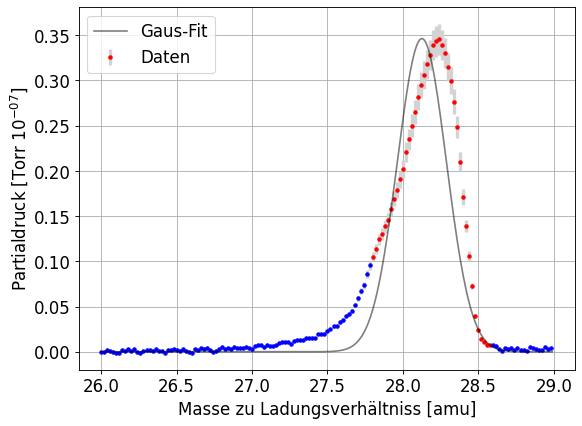

In [169]:
gaus1fit(27.8,28.6,'10%',x[0],data[13],err[13],1e7)